In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
import time

In [8]:
class Cal_Fac_Param:
    
    def __init__(self, excel_name, sheet_name, start_dates, final_dates, process_names = None):
        self.excel_name = excel_name
        self.sheet_name = sheet_name
        self.start_dates = start_dates
        self.final_dates = final_dates
        self.param_index = ['Ra', 'Ca', 'Te', 'Ce', 'Rd', 'Cd', 'u']
        
        if process_names == None:
            self.process_names = [None] * len(start_dates)
            for i in range(len(start_dates)):
                self.process_names[i] = 'process' + str(i)
        else:
            self.process_names = process_names
                
        #파일 읽기
        self.df = pd.read_excel('./' + self.excel_name, sheet_name= self.sheet_name)
    
    ## 전처리 함수
    def pre_process(self, del_inconsistency = True, drop_nan = True, zero_nan = False):
        
        df_dates = self.df[self.start_dates + self.final_dates]
        
        
        #데이터 형식이 8자리 숫자로만 되어 있을 경우 datetime으로 변환
        for col in df_dates :
            if df_dates[col].dtype == 'int64' :
                df_dates[col] = df_dates[col].apply(lambda x : datetime.strptime(str(x),'%Y%m%d'))
        
                
        print( "Raw Data's number of rows : " + str(df_dates.shape[0]) )

        # Nan 처리
        if drop_nan == True:
            df_dates.dropna(inplace = True)
            print("After deleting Nan, remains " + str(df_dates.shape[0]) + " rows")
        elif zero_nan == True:
            df_dates.fillna(0, inplace = True)        
        
        # Inconsistency 처리  -  시작일이 종료일보다 늦은 경우
        if del_inconsistency == True:
            for i in range(len(self.start_dates)) :
                df_dates.drop( df_dates[ df_dates[self.start_dates[i]] > df_dates[self.final_dates[i]] ].index, inplace = True )
                print("After deleting " + self.process_names[i] +"\'s inconsistent rows, remains " + str(df_dates.shape[0]) + " rows")
        
        self.df_dates = df_dates
    
    ## parameter 계산 함수
    def get_param(self):
        
        
        #분석하고자 하는 공정 시작 및 종료 날짜 칼럼 이름 저장
        df_s_dates = self.df_dates[self.start_dates]
        df_f_dates = self.df_dates[self.final_dates]
        
        
        #공정 te 계산 - CT이라고 해야하나?
        self.te_df = pd.DataFrame()
        for i in range(len(self.start_dates)):
            self.te_df[i] = df_f_dates[self.final_dates[i]] - df_s_dates[self.start_dates[i]]
        for col in self.te_df:
            self.te_df[col] = self.te_df[col].apply(lambda x: x.days)
        
        
        #ra, ta, ca 계산
        int_arr = np.zeros((len(df_s_dates)-1,len(self.start_dates)))
        np_s_dates = df_s_dates.to_numpy(copy = True)
        np_s_dates.sort(axis = 0)
        df_np_s_dates = pd.DataFrame(np_s_dates)
        #print(df_np_s_dates)
        
        for i in range(len(self.start_dates)) :
            for k in range(len(int_arr)) :
                int_arr[k][i] = (np_s_dates[k+1][i] - np_s_dates[k][i]).astype('timedelta64[D]') / np.timedelta64(1, 'D')
        
        #print('inter arrival time')
        #df_int_arr = pd.DataFrame(int_arr)
        #print(df_int_arr)
        
        self.ta = np.nanmean(int_arr, axis = 0)
        #print('ta')
        #print(self.ta)
        self.ra = 1 / self.ta
        #print('ra')
        #print(self.ra)
        self.stda = np.nanstd(int_arr, axis = 0)
        self.ca = self.stda / self.ta
        
        
        #rd, td, cd 계산
        int_dep = np.zeros((len(df_f_dates)-1,len(self.final_dates)))
        np_f_dates = df_f_dates.to_numpy(copy = True)
        np_f_dates.sort(axis = 0)
        
        for i in range(len(self.final_dates)) :
            for k in range(len(int_dep)) :
                int_dep[k][i] = (np_f_dates[k+1][i] - np_f_dates[k][i]).astype('timedelta64[D]') / np.timedelta64(1, 'D')
        
        self.td = np.nanmean(int_dep, axis = 0)
        self.rd = 1 / self.td
        self.stdd = np.nanstd(int_dep, axis = 0)
        self.cd = self.stdd / self.td
        
        
        #변수들 DataFrame, Numpy로 저장
        self.param = pd.DataFrame(columns = self.process_names, index = self.param_index)
        self.param.loc['Ra'] = self.ra
        self.param.loc['Ca'] = self.ca
        self.param.loc['Te'] = np.asarray(self.te_df.mean())
        self.param.loc['Ce'] = np.asarray(self.te_df.std() / self.te_df.mean())
        self.param.loc['Rd'] = self.rd
        self.param.loc['Cd'] = self.cd
        
        self.np_param = self.param.to_numpy(copy = True)
    
    
    #parameter 값들 반환하는 함수
    def show_param(self):
        return self.param
    


In [1]:
class Cal_Fac_Param_22:

    def __init__(self, param):
        self.param = param
        self.np_param = self.param.to_numpy(copy = True)
        self.process_names = list(param.columns)
        self.df_CT_WIP = pd.DataFrame(columns = param.columns, index = ['CTq', 'CT', 'WIPq', 'WIP'])
        
    # m값 입력, 각 공정별 m값을 가지고 있는 list 형태로 입력 
    def assume_m(self, m):
        self.m = np.asarray(m)
    
    
    # utilization 계산함수
    def cal_u(self, ra = None, te = None, m = None, inplace = True):
        if ra == None:
            ra = self.np_param[0][:]
        else:
            ra = np.asarray(ra)
        
        if te == None:
            te = self.np_param[2][:]
        else:
            te = np.asarray(te)
            
        if m == None:
            try:
                m = self.m
            except:
                print("m을 먼저 정의해야 합니다.")
        else:
            m = np.asarray(m)
        
        
        u = ra * te / m
        
        if inplace == True:
            self.u = u
            self.np_param[6][:] = u
            self.param.iloc[6] = u
            return self.u
        else:
            return u
        
    
    def cal_cd(self, ca, ce, u, m):
        cd = 1 + (1 - u*u)*(ca*ca - 1) + (u*u)*(ce*ce - 1)/np.sqrt(m)
        return cd
    
    
    # 공식에 의한 Cd 계산. Ca, Ce, u, m 값 입력 가능. Default는 param의 값들 사용. 
    
    def cal_ass_cd(self, ca = None, ce = None, u = None, m = None, cont = True, inplace = True):
        if ca == None:
            ca = self.np_param[1][:]
        else:
            try:
                checker = len(ca)
                ca = np.asarray(ca)
            except:
                temp = np.zeros(len(self.process_names))
                temp.fill(ca)
                ca = temp
        
        if ce == None:
            ce = self.np_param[3][:]
        else:
            ce = np.asarray(ce)
        
        if u == None:
            try:
                u = self.np_param[6][:]
            except:
                print("cal_u 함수를 통해 utilization을 먼저 정의해야 합니다.")
        else:
            u = np.asarray(u)
        
        if m == None:
            try:
                m = self.m
            except:
                print("assume_m 함수를 통해 m을 먼저 정의해야 합니다.")
        else:
            m = np.asarray(m)
        
        cd = np.zeros(len(self.process_names))
        if cont == True:
            ra = self.np_param[0][:]
            ra.fill(ra[0])
            self.np_param[0][:] = ra
            self.param.iloc[0] = ra
            u = self.cal_u()
            
            for i in range(len(self.process_names) - 1):
                cd[i] = self.cal_cd(ca = ca[i], ce = ce[i], u = u[i], m = m[i])
                ca[i+1] = cd[i]
                if i == len(self.process_names) - 2:
                    cd[i+1] = self.cal_cd(ca = ca[i+1], ce = ce[i+1], u = u[i+1], m = m[i+1])
            
        else:
            cd = self.cal_cd(ca, ce, u, m)
        
        
        if inplace == True:
            self.np_param[0][:] = ra
            self.param.iloc[0] = ra
            self.np_param[1][:] = ca
            self.param.iloc[1] = ca
            self.np_param[5][:] = cd
            self.param.iloc[5] = cd
            self.np_param[6][:] = u
            self.param.iloc[6] = u
            return cd
        else:
            return cd
            
        
 
    
    # CT, WIP 계산
    
    def cal_CT_WIP(self, ca = None, ce = None, u = None, m = None, te = None, ra = None, inplace = True):
        if ca == None:
            ca = self.np_param[1][:]
        else:
            ca = np.asarray(ca)
        
        if ce == None:
            ce = self.np_param[3][:]
        else:
            ce = np.asarray(ce)
        
        if u == None:
            try:
                u = self.np_param[6][:]
            except:
                print("cal_u 함수를 통해 utilization을 먼저 정의해야 합니다.")
        else:
            u = np.asarray(u)
        
        if m == None:
            try:
                m = self.m
            except:
                print("assume_m 함수를 통해 m을 먼저 정의해야 합니다.")
        else:
            m = np.asarray(m)
            u = self.cal_u(m = m, inplace = False)
        
        if te == None:
            te = self.np_param[2][:]
        else:
            te = np.asarray(te)
            u = self.cal_u(te = te, inplace = False)
            
        if ra == None:
            ra = self.np_param[0][:]
        else:
            ra = np.asarray(ra)
            u = self.cal_u(ra = ra, inplace = False)
            
               
            
        
        CTq = ( ((ca*ca) + (ce*ce)) / 2 ) * ( np.power(u, np.sqrt( 2*(m + 1) ) - 1 ) / ( m*(1 - u) ) ) * te
        CT = CTq + te
        WIPq = CTq * ra
        WIP = CT * ra
        
        if inplace == True:
            self.CTq = CTq
            self.CT = CT
            self.WIPq = WIPq
            self.WIP = WIP
            
            self.df_CT_WIP.iloc[0] = CTq
            self.df_CT_WIP.iloc[1] = CT
            self.df_CT_WIP.iloc[2] = WIPq
            self.df_CT_WIP.iloc[3] = WIP
            
            return self.df_CT_WIP
        else:
            df_CT_WIP = pd.DataFrame(columns = self.param.columns, index = ['CTq', 'CT', 'WIPq', 'WIP'])
            df_CT_WIP.iloc[0] = CTq
            df_CT_WIP.iloc[1] = CT
            df_CT_WIP.iloc[2] = WIPq
            df_CT_WIP.iloc[3] = WIP
            return df_CT_WIP
        
        

In [4]:
class sensitivity_analysis:
    
    def __init__(self, param, init_m):
        self.origin_param = param.copy()
        self.init_m = init_m
        #self.cfp3 = Cal_Fac_Param_22(param)
        #self.np_param = param.to_numpy(copy = True)
        #self.process_names = list(param.columns)
        #self.cfp3.assume_m(init_m)
        #self.cfp3.cal_ass_cd()
    
    def execute(self, var, out, start, stop, step, m_num = None, plot = True, check = False):
        self.cfp3 = Cal_Fac_Param_22(self.origin_param.copy())
        self.cfp3.assume_m(self.init_m)
        self.cfp3.cal_ass_cd()
        CT_WIP = ['CT', 'WIP']
        if out not in CT_WIP:
            print('out 파라미터에 CT 또는 WIP를 입력해야 합니다')
        
        index = np.arange(start, stop, step)
        out_list = list()
        
        
        if var == 'Ra':
            ra = index
            for x in ra:
                self.cfp3.np_param[0][:] = x
                self.cfp3.cal_ass_cd()
                temp = self.cfp3.cal_CT_WIP(inplace = False)
                if check == True:
                    print(x)
                    print(temp)
                    print('\n')
                out_list.append(temp.loc[out].sum())
                
        
        if var == 'Ca':
            ca = index
            for x in ca:
                self.cfp3.cal_ass_cd(ca = x)
                temp = self.cfp3.cal_CT_WIP(inplace = False)
                if check == True:
                    print(x)
                    print(temp)
                    print('\n')
                out_list.append(temp.loc[out].sum())
        
        if var == 'm':
            if m_num == None:
                print('몇 번째 프로세스의 기계 대수로 분석할 것인지 m_num 파라미터를 통해 입력해야 합니다')
                return
            else:
                temp_m = index
                for x in temp_m:
                    self.cfp3.m[m_num] = x
                    self.cfp3.cal_ass_cd()
                    temp = self.cfp3.cal_CT_WIP(inplace = False)
                    if check == True:
                        print(x)
                        print(temp)
                        print('\n')
                    out_list.append(temp.loc[out].sum())
        
        #result = pd.DataFrame({out : out_list}, index = index)
        result = pd.DataFrame({var : index, out : out_list})
        
        if plot == True:
            plt.plot(result[var], result[out], 'bo')
            plt.show()
            
        
        return result
            
        

#  def cal_CT_WIP(self, ca = None, ce = None, u = None, m = None, te = None, ra = None, inplace = True):
        

In [5]:
excel_name = 'spool_list_rev_1.xlsx'
sheet_name = 'spool_list_rev'
start_dates = ['cutting', 'palleting', 'stock_in', 'on_deck']
final_dates = ['welding', 'spool_out', 'stock_out', 'installation']
process_names = ['process1', 'process2', 'process3', 'process4']

In [313]:
excel_name = 'spool_list_rev_1.xlsx'
sheet_name = 'spool_list_rev'
start_dates = ['wo']
final_dates = ['stock_in']
process_names = ['process1', 'process2', 'process3', 'process4']

In [4]:
excel_name = 'block_transfer_list_Raw_Data.xlsx'
sheet_name = 'record'
start_dates = ['ASSY_ACTL_SD','OFT_ACTL_SD','PNT_ACTL_SD']
final_dates = ['ASSY_ACTL_FD','OFT_ACTL_FD','PNT_ACTL_FD']
process_names = ['process1', 'process2', 'process3']

In [6]:
temptime = time.time()

cfp = Cal_Fac_Param(excel_name, sheet_name, start_dates, final_dates, process_names)

print(time.time()-temptime)

6.302661180496216


In [7]:
param = cfp.pre_process()

Raw Data's number of rows : 14885
After deleting Nan, remains 14760 rows
After deleting process1's inconsistent rows, remains 14760 rows
After deleting process2's inconsistent rows, remains 14760 rows
After deleting process3's inconsistent rows, remains 14760 rows
After deleting process4's inconsistent rows, remains 14634 rows


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\frame.py:3940: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


In [233]:
cfp.get_param()

In [234]:
param = cfp.show_param()
param

,process1,process2,process3,process4
Ra,11.441,11.6227,11.6598,20.3519
Ca,30.024,16.2792,14.7248,9.80394
Te,11.4584,1.55023,104.943,108.393
Ce,1.31768,3.27157,1.4657,0.999048
Rd,11.5039,11.3699,19.6153,20.1279
Cd,19.1808,16.1128,10.6084,10.018
u,NaN,NaN,NaN,NaN


In [235]:
##### 엑셀 파일과 Te 다른 이유 -> 여기서는 + 1일 안함
#                              -> oft에서 inconsistency 발생하면 나머지 공정에서도 다 지움.

In [236]:
cfp22 = Cal_Fac_Param_22(param)

In [237]:
cfp22.param

,process1,process2,process3,process4
Ra,11.441,11.6227,11.6598,20.3519
Ca,30.024,16.2792,14.7248,9.80394
Te,11.4584,1.55023,104.943,108.393
Ce,1.31768,3.27157,1.4657,0.999048
Rd,11.5039,11.3699,19.6153,20.1279
Cd,19.1808,16.1128,10.6084,10.018
u,NaN,NaN,NaN,NaN


In [238]:
m = [145, 135, 112]
cfp22.assume_m(m)

In [239]:
m = [150, 20, 1300, 2500]
cfp22.assume_m(m)

In [240]:
cfp22.cal_u()

array([0.8739668575210641, 0.9008915716639295, 0.9412412238536523,
       0.8823975562463089], dtype=object)

In [241]:
cfp22.cal_ass_cd(ca = 1, cont = True, inplace = True)

array([1.04591858, 2.72635842, 1.9728314 , 3.18042617])

In [242]:
cfp22.cal_ass_cd()

array([1.04591858, 2.72635842, 1.9728314 , 3.18042617])

In [243]:
cfp22.u

array([0.8739668575210641, 0.8868041350468235, 0.9235791524130834,
       0.49604678885152154], dtype=object)

In [244]:
cfp22.param

,process1,process2,process3,process4
Ra,11.441,11.441,11.441,11.441
Ca,1,1.04592,2.72636,1.97283
Te,11.4584,1.55023,104.943,108.393
Ce,1.31768,3.27157,1.4657,0.999048
Rd,11.5039,11.3699,19.6153,20.1279
Cd,1.04592,2.72636,1.97283,3.18043
u,0.873967,0.886804,0.923579,0.496047


In [245]:
cfp22.cal_CT_WIP()

,process1,process2,process3,process4
CTq,0.0913007,2.09092,0.0949647,1.23975e-22
CT,11.5497,3.64114,105.038,108.393
WIPq,1.04457,23.9221,1.08649,1.41839e-21
WIP,132.14,41.6582,1201.74,1240.12


In [246]:
cfp22.cal_CT_WIP(ra = 12, inplace = False)

,process1,process2,process3,process4
CTq,0.301641,4.4001,2.52031,3.62517e-21
CT,11.76,5.95032,107.464,108.393
WIPq,3.6197,52.8012,30.2437,4.35021e-20
WIP,141.12,71.4039,1289.56,1300.71


In [247]:
cfp22.cal_ass_cd(ca=1)

array([1.04591858, 2.72635842, 1.9728314 , 3.18042617])

In [248]:
cfp22.param

,process1,process2,process3,process4
Ra,11.441,11.441,11.441,11.441
Ca,1,1.04592,2.72636,1.97283
Te,11.4584,1.55023,104.943,108.393
Ce,1.31768,3.27157,1.4657,0.999048
Rd,11.5039,11.3699,19.6153,20.1279
Cd,1.04592,2.72636,1.97283,3.18043
u,0.873967,0.886804,0.923579,0.496047


In [249]:
cfp22.np_param

array([[11.440969507427678, 11.440969507427678, 11.440969507427678,
        11.440969507427678],
       [1.0, 1.045918580992574, 2.726358416093804, 1.972831398258028],
       [11.458384583845838, 1.5502255022550226, 104.94328276616099,
        108.39264725980593],
       [1.3176805234813007, 3.2715689762911713, 1.4657022626561327,
        0.9990476783760734],
       [11.503930817610062, 11.369852369852369, 19.615281501340483,
        20.127922971114167],
       [1.045918580992574, 2.726358416093804, 1.972831398258028,
        3.1804261674486507],
       [0.8739668575210641, 0.8868041350468235, 0.9235791524130834,
        0.49604678885152154]], dtype=object)

In [298]:
sens_anal = sensitivity_analysis(param, init_m = m)

10
       process1 process2 process3     process4
CTq   0.0913007 -9.79508  1.10379  7.29624e-21
CT      11.5497 -8.24485  106.047      108.393
WIPq    1.04457 -112.065  12.6284  8.34761e-20
WIP      132.14 -94.3291  1213.28      1240.12


11
       process1 process2  process3     process4
CTq   0.0913007 -8.74249  0.729924   3.3144e-21
CT      11.5497 -7.19226   105.673      108.393
WIPq    1.04457 -100.023   8.35104  3.79199e-20
WIP      132.14 -82.2864      1209      1240.12


12
       process1 process2  process3     process4
CTq   0.0913007 -7.90737  0.508016  1.68823e-21
CT      11.5497 -6.35715   105.451      108.393
WIPq    1.04457  -90.468    5.8122   1.9315e-20
WIP      132.14 -72.7319   1206.47      1240.12


13
       process1 process2  process3     process4
CTq   0.0913007 -7.32329  0.369628  9.52175e-22
CT      11.5497 -5.77307   105.313      108.393
WIPq    1.04457 -83.7856    4.2289  1.08938e-20
WIP      132.14 -66.0495   1204.88      1240.12


14
       process1 proces

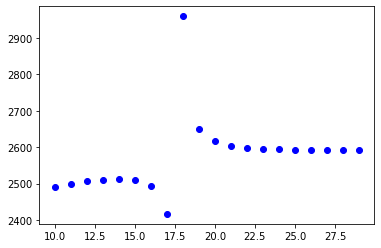

,m,WIP
0,10,2491.208792
1,11,2498.974081
2,12,2505.989739
3,13,2511.088865
4,14,2513.096850
5,15,2509.717343
6,16,2493.547345
7,17,2416.641553
8,18,2959.355276
9,19,2649.249521


In [300]:
sens_anal.execute('m', 'WIP', 10, 30, 1, m_num = 1, check = True)

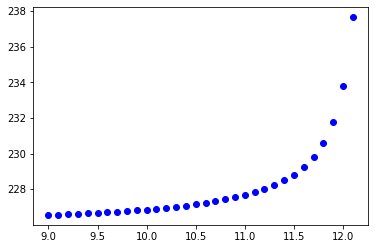

,Ra,CT
0,9.0,226.554696
1,9.1,226.573816
2,9.2,226.594695
3,9.3,226.617513
4,9.4,226.642471
5,9.5,226.669797
6,9.6,226.699746
7,9.7,226.732610
8,9.8,226.768718
9,9.9,226.808449


In [303]:
sens_anal.execute('Ra', 'CT', 9, 12.2, 0.1)

In [287]:
sens_anal.execute('Ca', 'CT', 0.8, 1.3, 0.1)

,Ca,CT
0,0.8,228.577513
1,0.9,228.598047
2,1.0,228.621724
3,1.1,228.648787
4,1.2,228.679506


In [282]:
sens_anal.origin_param

,process1,process2,process3,process4
Ra,11.441,11.441,11.441,11.441
Ca,1,1.04592,2.72636,1.97283
Te,11.4584,1.55023,104.943,108.393
Ce,1.31768,3.27157,1.4657,0.999048
Rd,11.5039,11.3699,19.6153,20.1279
Cd,1.04592,2.72636,1.97283,3.18043
u,0.873967,0.886804,0.923579,0.496047
